In [1]:
import matplotlib
matplotlib.use('Agg')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Helpers
import sys
sys.path.insert(0,'../../')
from utils import a,results_path,grid_search,estimator_result,cross_validate,rfecv
from scipy.sparse import csr_matrix,save_npz,load_npz
from sklearn.model_selection import cross_val_score,LeaveOneOut,StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
import pickle

# Algorithms
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
train_X = load_npz(data_path + 'version_1/'+ 'train_bin.npz')
test_X = load_npz(data_path + 'version_1/'+ 'test_bin.npz')

train_y = pd.read_csv(data_path + 'train_Y.csv')['CMV_status']
test_y = pd.read_csv(data_path + 'test_Y.csv')['CMV_status']

with open(data_path + 'sorted_TCRs_ind.pkl', 'rb') as f:
    TCRs_ind = pickle.load(f)

## Define classifier

In [5]:
rf = RandomForestClassifier(n_estimators=100,random_state=0)
print(rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


## RFE

The number of features with the smallest values: 1000
Optimal number of features : 900
Best score: 0.987562944718117
AUROC: 0.8635976129582268 Accuracy:  0.7583333333333333

The number of features with the smallest values: 900
Optimal number of features : 810
Best score: 0.9882832903276254
AUROC: 0.8611821540210287 Accuracy:  0.775

The number of features with the smallest values: 800
Optimal number of features : 800
Best score: 0.9854488232074438
AUROC: 0.868428530832623 Accuracy:  0.7666666666666667

The number of features with the smallest values: 700
Optimal number of features : 700
Best score: 0.9848477206974746
AUROC: 0.8790849673202614 Accuracy:  0.7833333333333333

The number of features with the smallest values: 600
Optimal number of features : 600
Best score: 0.9870163812651498
AUROC: 0.890593918726911 Accuracy:  0.75

The number of features with the smallest values: 500
Optimal number of features : 500
Best score: 0.9857805536007506
AUROC: 0.8816425120772946 Accuracy:  0.783

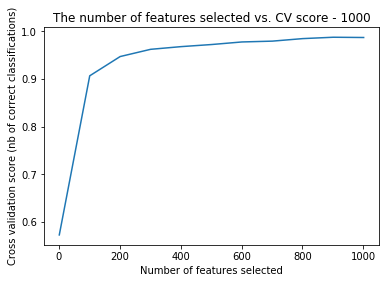

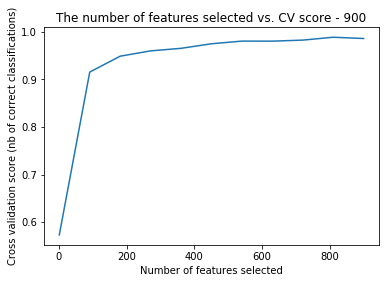

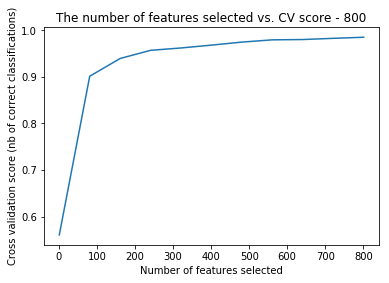

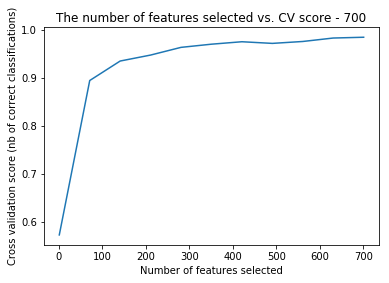

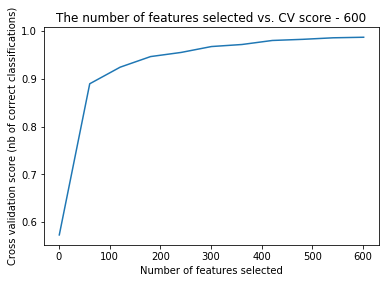

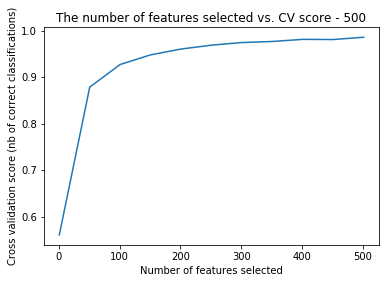

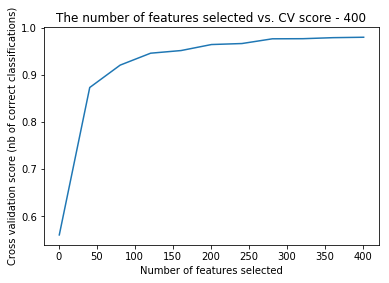

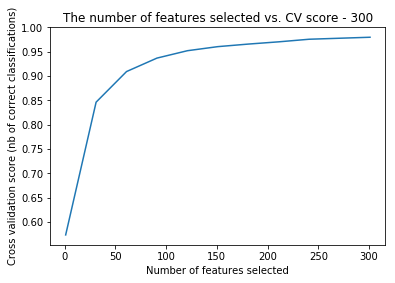

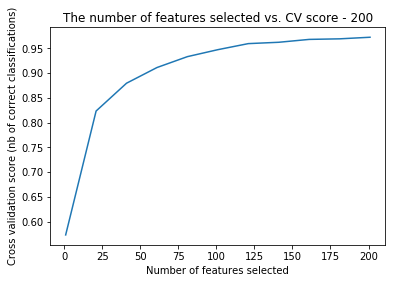

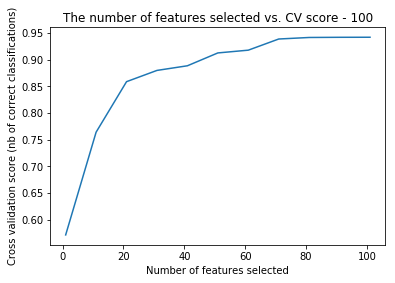

In [15]:
num = np.linspace(1000,100,num=10,dtype=int)
for i in num:
    print('The number of features with the smallest values:',i)
    ind = TCRs_ind[:i]
    step = int(0.1*i)
    rfecv = RFECV(rf,cv=StratifiedKFold(10),scoring='roc_auc',step = step)
    rfecv.fit(train_X[:,ind],train_y)

    print("Optimal number of features : %d" % rfecv.n_features_)
    print('Best score:',max(rfecv.grid_scores_))
    
    print('AUROC:',roc_auc_score(test_y,rfecv.predict_proba(test_X[:,ind])[:,1]),'Accuracy: ',accuracy_score(test_y,
        rfecv.predict(test_X[:,ind])))
    
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.title('The number of features selected vs. CV score - %d'%i)
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1,(len(rfecv.grid_scores_))*step,step), rfecv.grid_scores_)
    print()

**Choose 300 features with the smallest p-values to the next stage**

The optimal number of features:
Best cv_auroc:0.980 282
Best cv_acc:0.916 285
Best test_auroc:0.927 69
Best test_acc:0.908 68


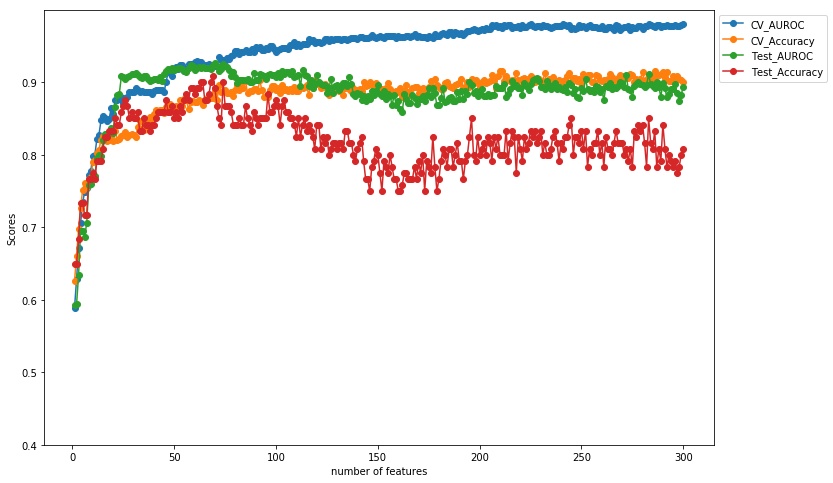

In [18]:
nums = np.linspace(1,300,300,dtype=int)
cv_acc = []
cv_auroc = []
test_acc = []
test_auroc = []
for i in nums:
    train_X_sub = train_X[:,TCRs_ind[:int(i)]]
    test_X_sub = test_X[:,TCRs_ind[:int(i)]]
    cv_results = cross_validate(rf,train_X_sub,train_y,scoring=('accuracy', 'roc_auc'),cv=StratifiedKFold(10))
    cv_acc.append(np.mean(cv_results['test_accuracy']))
    cv_auroc.append(np.mean(cv_results['test_roc_auc']))

    # fit training set
    rf.fit(X=train_X_sub, y=train_y)

    # predict test_Y
    predict_test = rf.predict(test_X_sub)
    test_acc.append(accuracy_score(test_y, predict_test))

    # AUROC of testing set
    predict_test_prob = rf.predict_proba(test_X_sub)
    pos_prob_test = predict_test_prob[:, 1]
    test_auroc.append(roc_auc_score(test_y, pos_prob_test))
    
    
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
line1 = ax.plot(list(nums),cv_auroc,label='CV_AUROC',marker='o')
line2 = ax.plot(list(nums),cv_acc,label='CV_Accuracy',marker='o')
line3 = ax.plot(list(nums),test_auroc,label='Test_AUROC',marker='o')
line4 = ax.plot(list(nums),test_acc,label='Test_Accuracy',marker='o')

print('The optimal number of features:')
print('Best cv_auroc:%.3f'%max(cv_auroc),np.argmax(cv_auroc))
print('Best cv_acc:%.3f'%max(cv_acc),np.argmax(cv_acc))
print('Best test_auroc:%.3f'%max(test_auroc),np.argmax(test_auroc))
print('Best test_acc:%.3f'%max(test_acc),np.argmax(test_acc))

ax.set_ylabel('Scores')
ax.set_xlabel('number of features')
# ax.set_xticks(range(50,200,10))
ax.set_yticks(np.arange(0.4,1,0.1))
ax.legend(loc='best', bbox_to_anchor=(1,1))

plt.show()

In [6]:
for i in [282,285,69,68]:
    print(i)
    train_X_sub = train_X[:,TCRs_ind[:i]]
    test_X_sub = test_X[:,TCRs_ind[:i]]
    estimator_result(rf,train_X_sub,train_y,test_X_sub,test_y)

282
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Cross validation:
accuracy score 0.9047767857142859
AUROC 0.9776739776370318
________________________________________________________________________________
Training set:
accuracy score 1.0
AUROC 1.0
log-loss: 0.08635517935934582
________________________________________________________________________________
Testing set;
accuracy score: 0.7833333333333333
AUROC 0.8964194373401535
log-loss: 0.43121184667983736
classification_report
             precision    recall  f1-score   support

          0       0.75      0.93      0.83        69
          1       0.86      0.59      0.70  

**The best one: The 69 features with smallest p-values**